In [227]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style(style='darkgrid') 
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
%matplotlib inline


import scipy.stats as stats
from scipy.stats import f_oneway
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


import warnings
warnings.filterwarnings('ignore')

# Scrubbing and initial exploration of data

In [228]:
df = pd.read_csv("kc_house_data.csv")
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [229]:
# Removing columns that aren't required for modeling
cols_to_drop = ['id']
df.drop(columns=cols_to_drop, inplace=True)

In [230]:
# checking missing values and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 20 columns):
date             21613 non-null object
price            21613 non-null float64
bedrooms         21613 non-null int64
bathrooms        21613 non-null float64
sqft_living      21613 non-null int64
sqft_lot         21613 non-null int64
floors           21613 non-null float64
waterfront       21613 non-null int64
view             21613 non-null int64
condition        21613 non-null int64
grade            21613 non-null int64
sqft_above       21613 non-null int64
sqft_basement    21613 non-null int64
yr_built         21613 non-null int64
yr_renovated     21613 non-null int64
zipcode          21613 non-null int64
lat              21613 non-null float64
long             21613 non-null float64
sqft_living15    21613 non-null int64
sqft_lot15       21613 non-null int64
dtypes: float64(5), int64(14), object(1)
memory usage: 3.3+ MB


In [231]:
df['date'] = pd.to_datetime(df['date'])

In [232]:
df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


# Outliers, Normality Checks, Categorical Variables 

In order to keep track of which variables will be transformed, let's create a "to_normalize" list and store features in it along the way

In [233]:
categorical = []
X_cols = []
Y = []

filt = df['price'] > 2000000
df.drop(index=df.loc[filt].index, inplace=True)


## Dependent Variable

In [234]:
def ks_plot(data, distribution=stats.norm):
    
    std = data.std()
    loc = data.mean()
    min_ = data.min()
    max_ = data.max()
    x = np.linspace(loc-4*std, loc+4*std, len(data))
    
    y = distribution.cdf(x, loc=loc, scale=std)

    plt.figure(figsize=(10,4))
    plt.plot(np.sort(data), np.linspace(0, 1, len(data)))
    plt.plot(x, y)
    plt.legend(['ECDF', 'CDF'])
    plt.title('Comparing CDFs for K-S test, Sample size=' + str(len(data)))
    plt.show()
    return

In [235]:
def dep_var_dist(dependent_variable ='price', df=df, logtransform=False):
    log_trans = ''
    if logtransform:
        df = df.apply(np.log)
        log_trans = 'Log Transformed '

    # dependent variable PRICE

    f, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 5), sharex=True)
    f.suptitle('Distribution of '+ log_trans + dependent_variable.title() + ' Data', x=0.52, y=1, fontsize=16)

    plt.subplots_adjust(hspace=0.3)

    data = df[dependent_variable]
    sns.boxplot(x=data, ax=ax1)
    ax1.set_title('Boxplot', fontsize=12)
    ax1.set_xlabel('')


    sns.distplot(data, kde=True, hist=True,
             hist_kws={"linewidth": 1,"edgecolor" :'red', "alpha": 0.4,
                         "color":  "w", "label": "Histogram"},
             kde_kws = {'linewidth': 1, 'color': "blue",  "alpha": 0.7,
                                    'label':'Kernel Density Estimation Plot'} ,ax=ax2)


    ax2.set_title('Distplot', fontsize=12)
    ax2.set_xlabel(dependent_variable)
    plt.show()

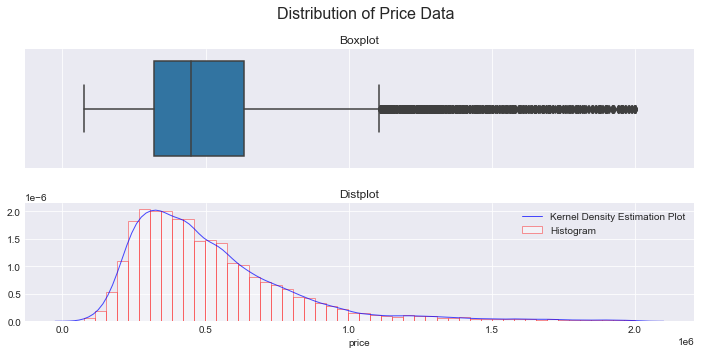

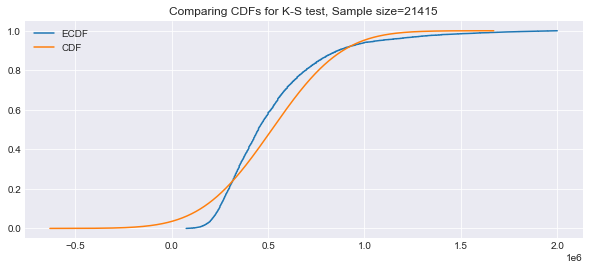

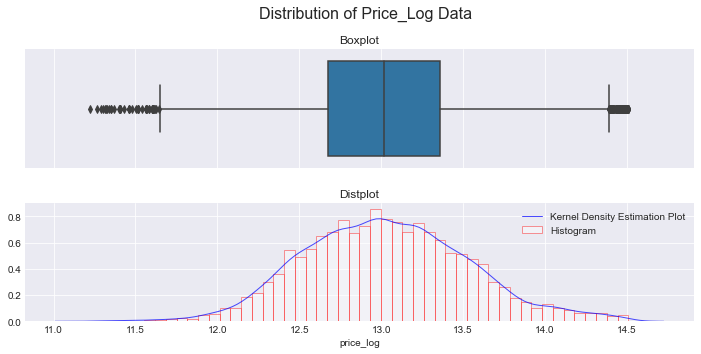

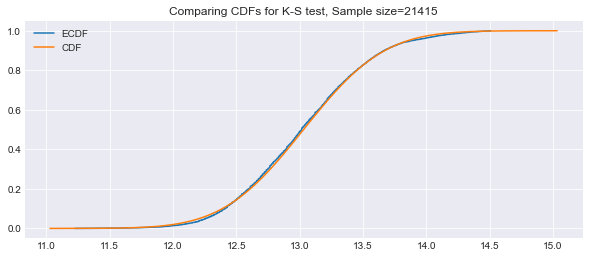

In [236]:
# plots dependent variable as is
df['price']
dep_var_dist()

# plots log transformed Dep Variable
data = df[['price']]
ks_plot(df['price'])
d_stat, p_value =  stats.kstest(data, 'norm')


data['price_log'] = data['price'].apply(np.log)
dep_var_dist(dependent_variable='price_log', df=data)
ks_plot(data['price_log'])
d_stat, p_value =  stats.kstest(data['price_log'], 'norm')

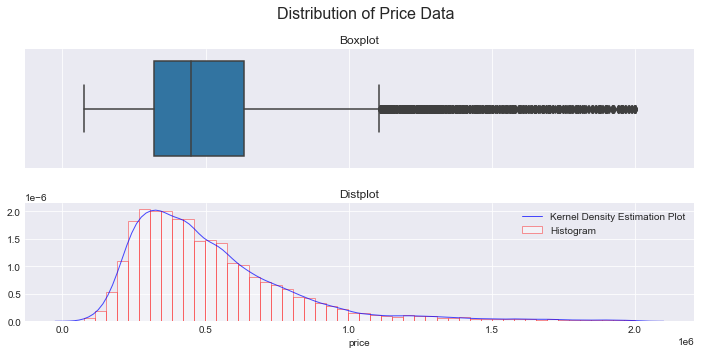

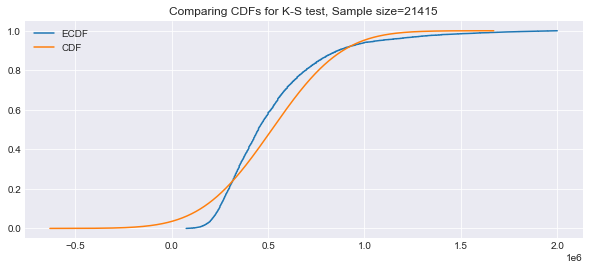

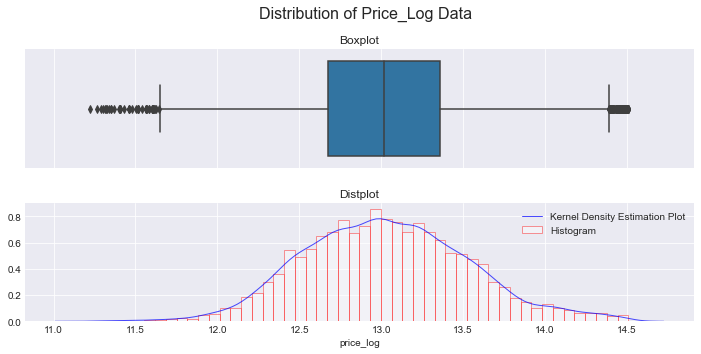

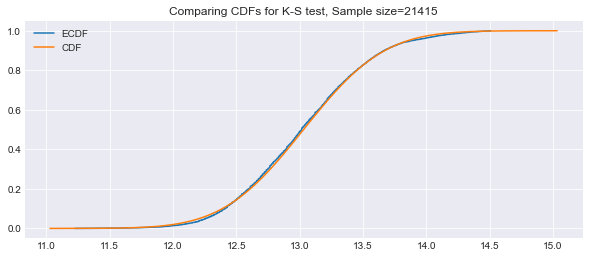

In [237]:
# plots dependent variable as is
dep_var_dist()

# plots log transformed Dep Variable
data = df[['price']]
ks_plot(df['price'])
d_stat, p_value =  stats.kstest(data, 'norm')


data['price_log'] = data['price'].apply(np.log)
dep_var_dist(dependent_variable='price_log', df=data)
ks_plot(data['price_log'])
d_stat, p_value =  stats.kstest(data['price_log'], 'norm')


The variable 'price' is somewhat normal, even though it is strongly skewed by outliers. The distribution becomes less skewed if we look at log transformed price

In [238]:
df['price_log'] = df['price'].apply(np.log)
Y.append('price_log')

## Independent Variables

In [239]:
def check_distribution(cols, df=df):
    
    
    for col in cols:
        fig, axes = plt.subplots(2, 
                                 sharex='col',  gridspec_kw={"height_ratios": (.15, .85)}, 
                                 figsize = (15,5))
        fig.suptitle(col.title(), fontsize=20).set_position([.5, 1.05])
        
        # top  plot
        sns.boxplot(x=df[col], ax = axes[0],color = 'red')
        axes[0].set_title('Boxplot', fontsize=12)
        axes[0].set_xlabel('')
        
        # bottom plot
        sns.distplot(df[col], hist=True, 
                     hist_kws={"linewidth": 1, "edgecolor" :'red', "alpha": 0.4,
                               "color":  "w", "label": "Histogram"},
                     kde=True, kde_kws = {'linewidth': 1, 'color': "blue", 
                                          "alpha": 0.7, 'label':'Kernel Density Estimation Plot'},
                     fit= stats.norm, 
                     fit_kws = {'color' : 'green', 'label' : 'parametric fit',
                                "alpha": 0.7, 'linewidth':3},
                 ax=axes[1])
        axes[1].set_title('Density Estimations', fontsize=12)
        axes[1].set_ylabel('frequency/probability')
        axes[1].set_xlabel(col)
        axes[1].legend()
        plt.show()
        
def boxplots_category(col, df=df):
    f, axes = plt.subplots(1, 2, figsize=(15,8), 
                           sharey = True, 
                           gridspec_kw={"width_ratios": (.1, .9)})
    f.tight_layout()
    data = df[[ col, 'price_log']]
    a = sns.boxplot(x=df['price_log'], orient='v', ax=axes[0])
    b = sns.boxplot(x=df[col], y=df['price_log'], ax=axes[1])
    b.set_title("Price_log Distribution by "+col,fontsize=20)
    b.set_xlabel(col,fontsize=15)
    b.set_ylabel("",)
    b.tick_params(labelsize=9)
    plt.xticks(rotation=70)
    plt.show()


### date

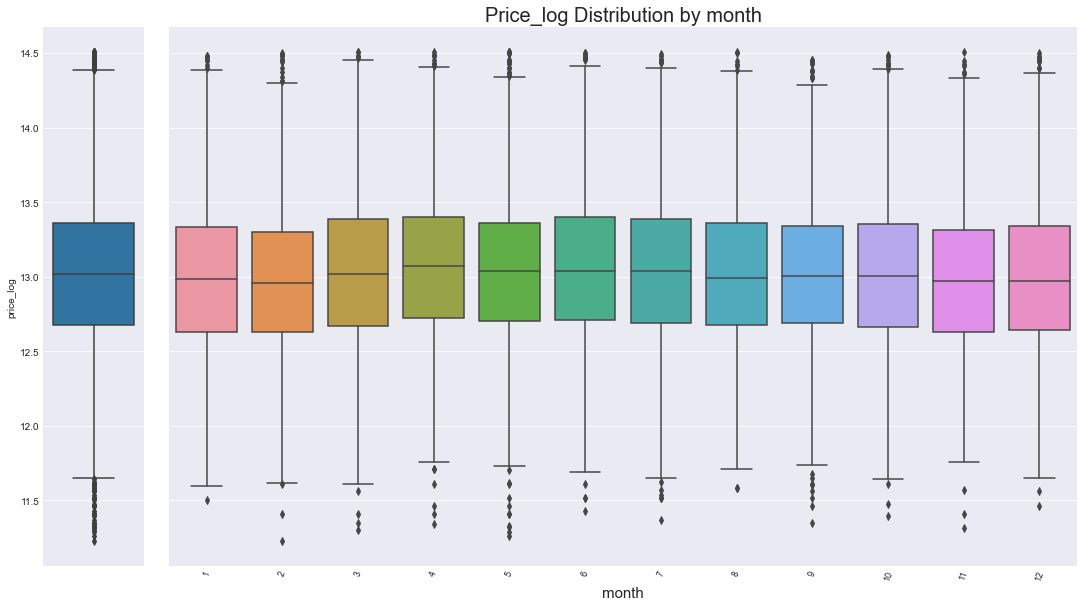

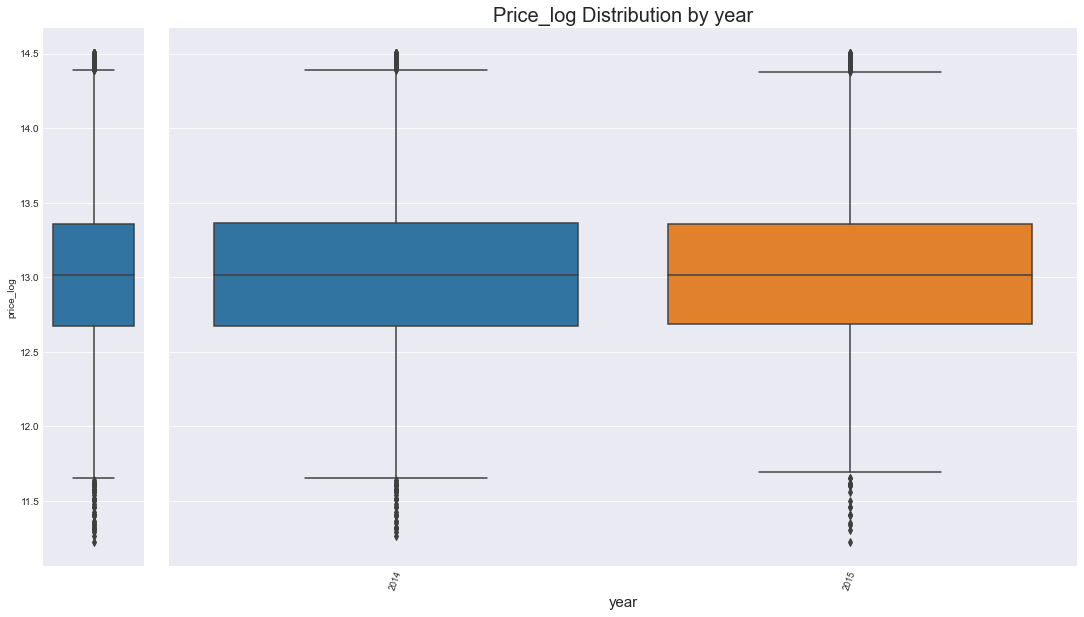

In [240]:
data = df.sort_values(by=['date'])
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
boxplots_category('month', df=data)
boxplots_category('year', df=data)

### sqft_living

Square footage of the property's interior living space

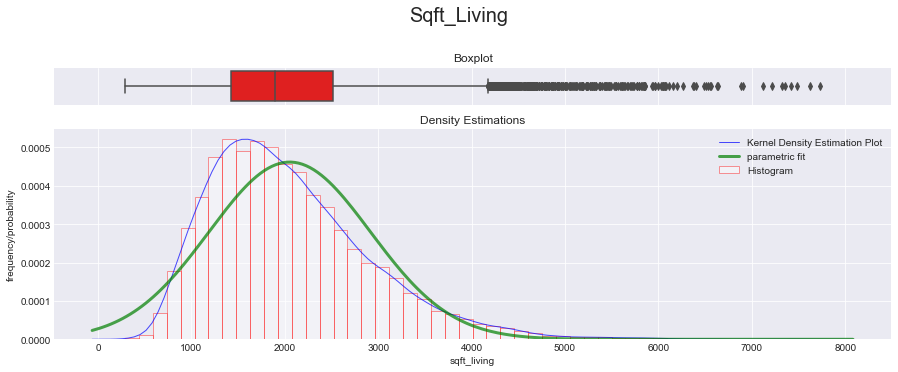

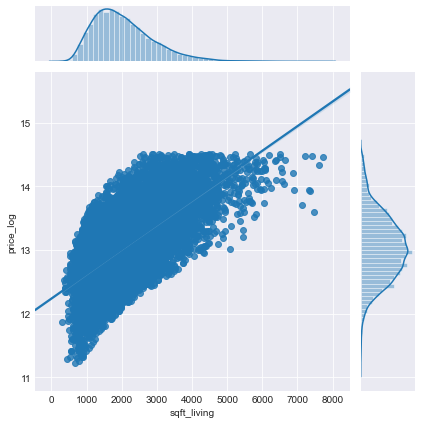

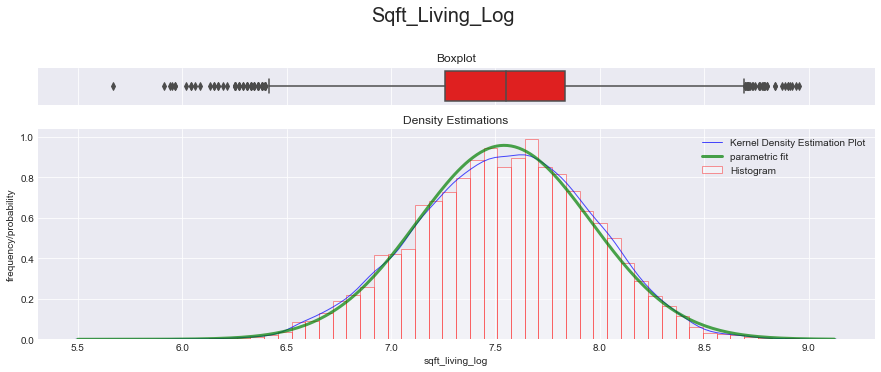

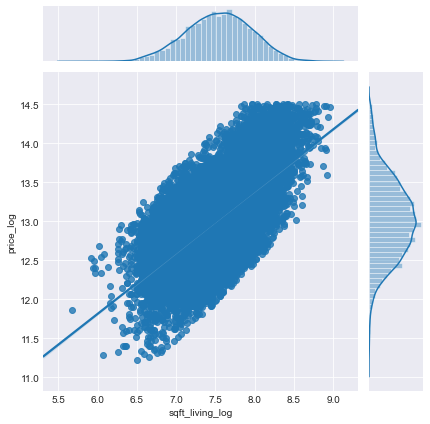

In [241]:
data = pd.concat([df['sqft_living'],df['sqft_living'].apply(np.log), 
                  df['price_log']], axis=1)
data.columns = ['sqft_living', 'sqft_living_log', 'price_log']


# distributions as is
check_distribution(cols=['sqft_living'], df=df)
sns.jointplot(x=data['sqft_living'], y=data['price_log'], kind='reg')

# distributions of log tranformed variable

check_distribution(cols=['sqft_living_log'], df=data)

# jointplot of log transformed dependent and independent variables
a = sns.jointplot(x='sqft_living_log', y='price_log', data=data, kind='reg')

- there is a clear linear relationship price_log and sqft_living_log
- log transformation was effective in controlling the effects of outliers, the right skew and in making the relationship more linear

In [242]:
df['sqft_living_log'] = df['sqft_living'].apply(np.log)
X_cols.append('sqft_living_log')

### sqft_living15

The square footage of interior housing living space for the nearest 15 neighbors

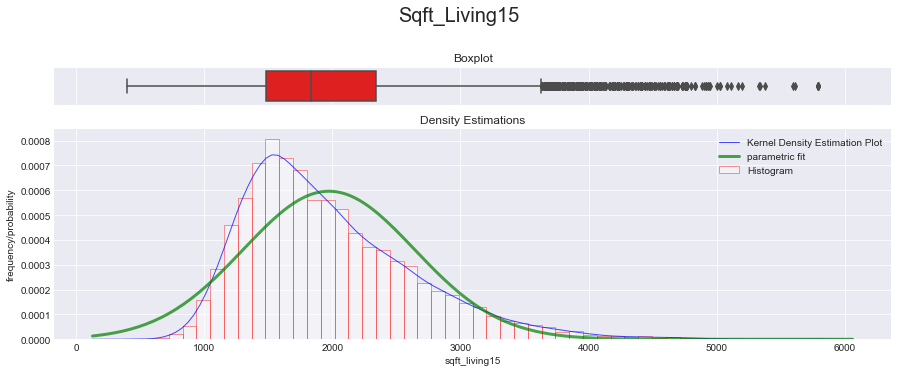

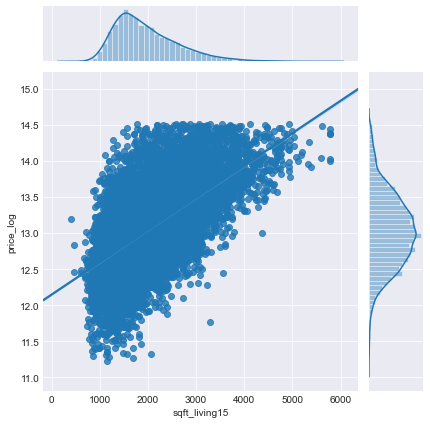

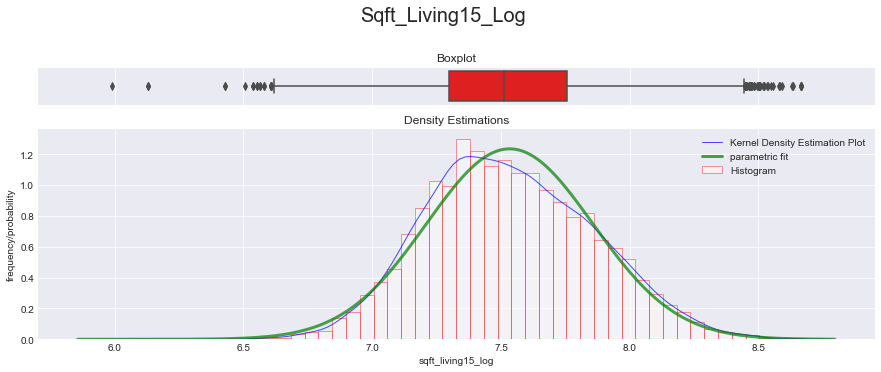

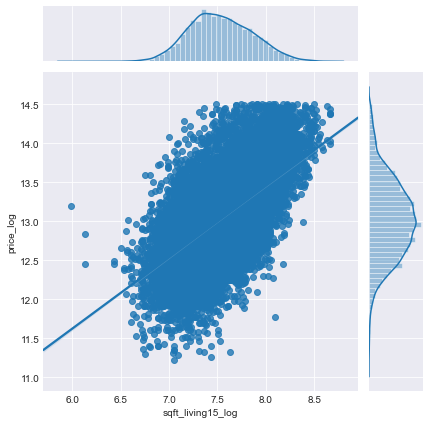

In [243]:
data = pd.concat([df['price_log'], df['sqft_living15'], df['sqft_living15'].apply(np.log)], axis=1)
data.columns = ['price_log', 'sqft_living15', 'sqft_living15_log']
# distributions as is
check_distribution(cols=['sqft_living15'])
sns.jointplot(x='sqft_living15', y='price_log', data=data, kind='reg')

# distributions of log tranformed variable
check_distribution(cols=['sqft_living15_log'], df=data)

# jointplot of log transformed dependent and independent variables
sns.jointplot(x='sqft_living15_log', y='price_log', data=data, kind='reg')

- there is a clear linear relationship price_log and sqft_living15_log
- log transformation was effective in controlling the effects of outliers and the right skew

In [244]:
df['sqft_living15_log'] = df['sqft_living15'].apply(np.log)
X_cols.append('sqft_living15_log')

### sqft_above

The square footage of the interior housing space that is not below ground level

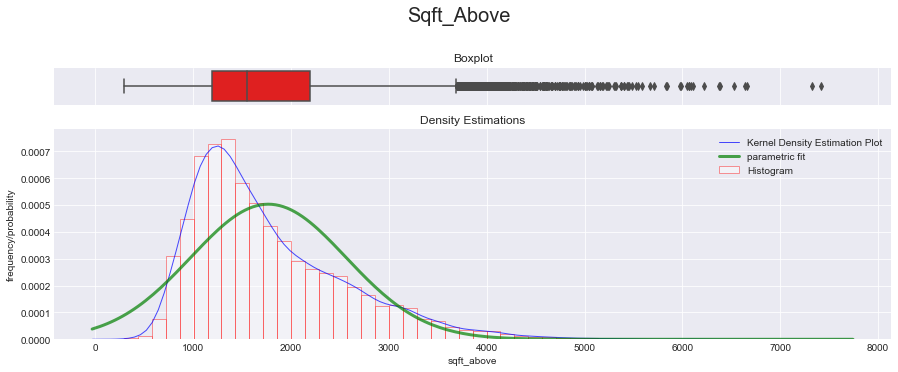

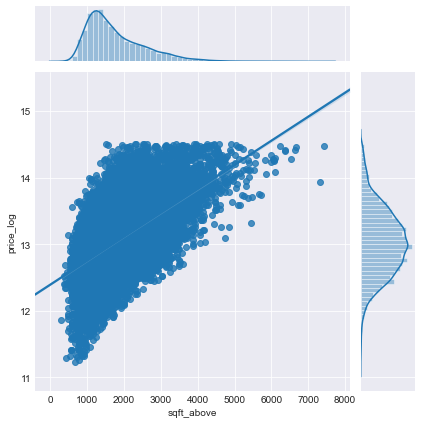

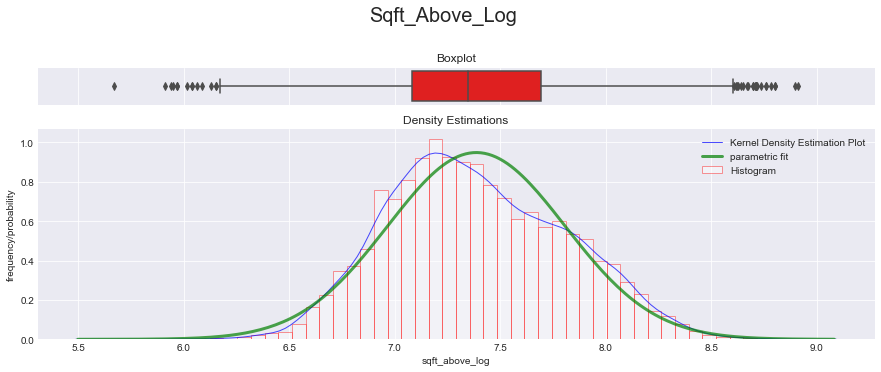

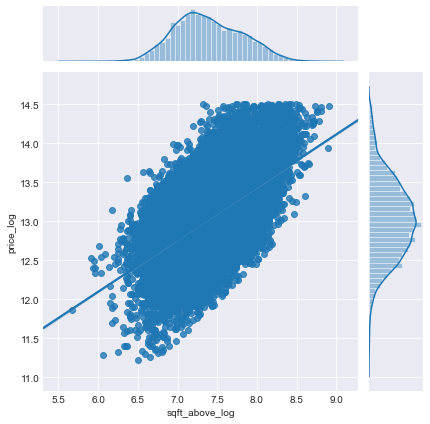

In [245]:
data = pd.concat([df['price_log'], df['sqft_above'], df['sqft_above'].apply(np.log)], axis=1)
data.columns = ['price_log', 'sqft_above', 'sqft_above_log']

# distributions as is
check_distribution(cols=['sqft_above'], df=df)
sns.jointplot(x='sqft_above', y='price_log', data=data, kind='reg')

# distributions of log tranformed variable
check_distribution(cols=['sqft_above_log'], df=data)

# jointplot of log transformed dependent and independent variables
a = sns.jointplot(x='sqft_above_log', y='price_log', data=data, kind='reg')

- there is a linear relationship price_log and sqft_above_log
- log transformation was effective in controlling the effects of outliers and the right skew

In [246]:
df['sqft_above_log'] = df['sqft_above'].apply(np.log)
X_cols.append('sqft_above_log')

### sqft_basement

The square footage of the interior housing space that is below ground level

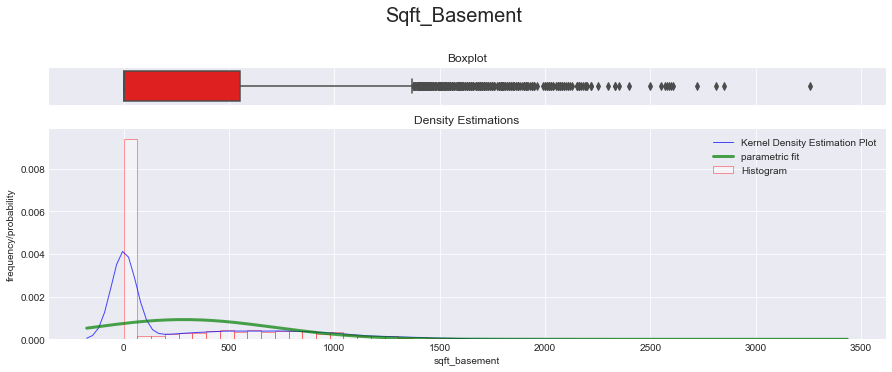

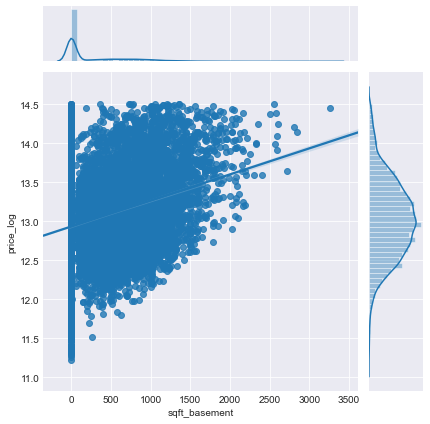

In [247]:
data = pd.concat([df['price_log'], df['sqft_basement'], (df['sqft_basement']+1).apply(np.log)], axis=1)
data.columns = ['price_log', 'sqft_basement', 'sqft_basement_log']


# distributions as is
check_distribution(cols=['sqft_basement'], df=df)
sns.jointplot(x=data['sqft_basement'], y=data['price_log'], kind='reg')


In [248]:
X_cols.append('sqft_basement')

### Sqft_lot

Square footage of the land space

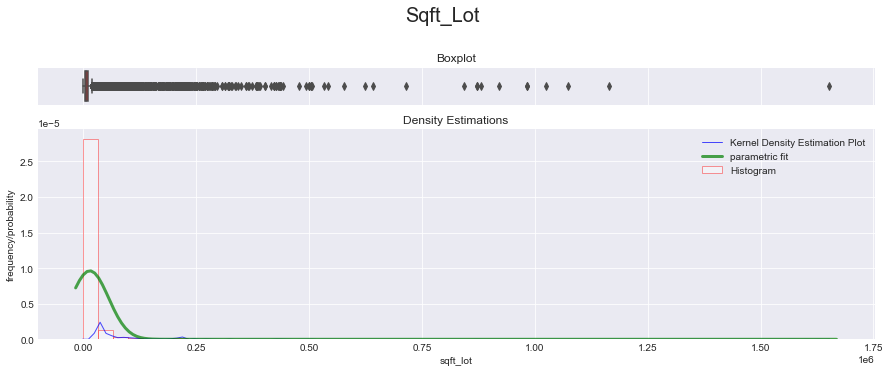

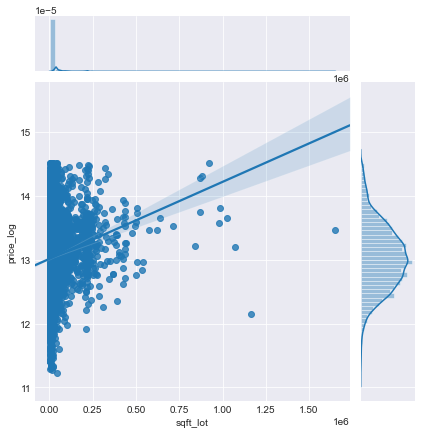

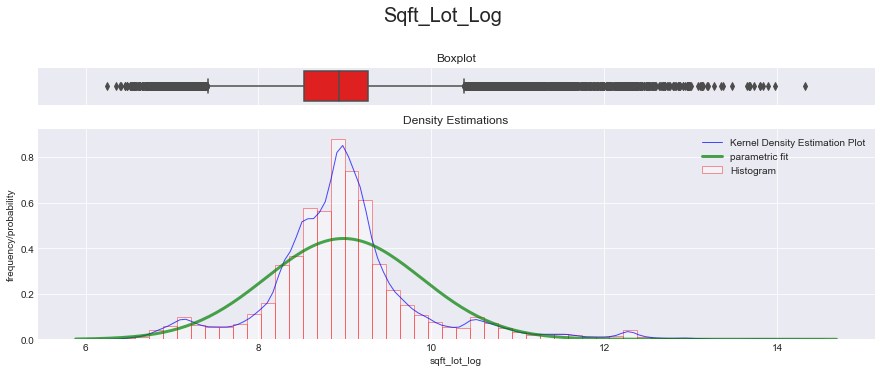

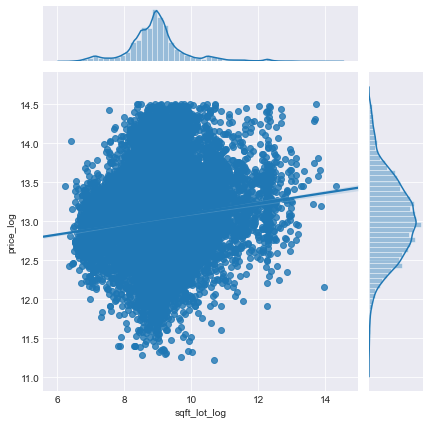

In [249]:
# distribution of lot areas - as is
data = pd.concat([df['sqft_lot'],df['sqft_lot'].apply(np.log), 
                  df['price'].apply(np.log)], axis=1)
data.columns = ['sqft_lot', 'sqft_lot_log', 'price_log']
check_distribution(cols=['sqft_lot'], df=data)
sns.jointplot(x='sqft_lot', y='price_log', data=data, kind='reg')

# distribution of lot areas - log transformed 
check_distribution(cols=['sqft_lot_log'], df=data)

a = sns.jointplot(x='sqft_lot_log', y='price_log', data=data, kind='reg')

- log transformation has improved the distribution by reducing skew and making it look more normal
- linear relationship with price exists, but data show high heteroscedasticity

In [250]:
df['sqft_lot_log'] = df['sqft_lot'].apply(np.log)
X_cols.append('sqft_lot_log')

### sqft_lot15

The square footage of the land lots of the nearest 15 neighbors

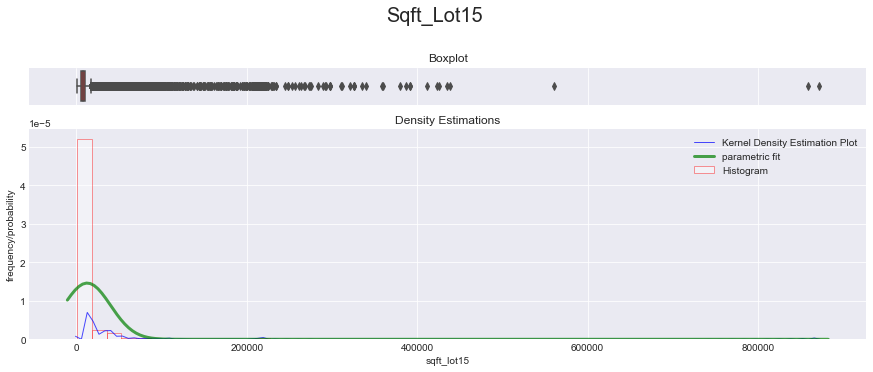

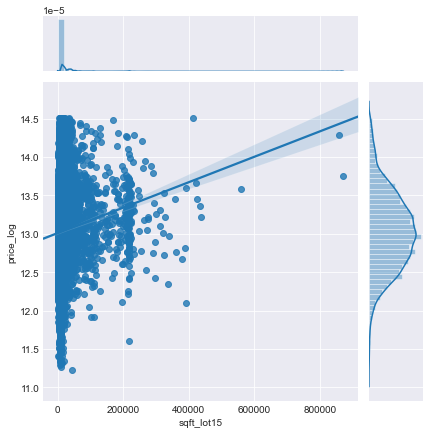

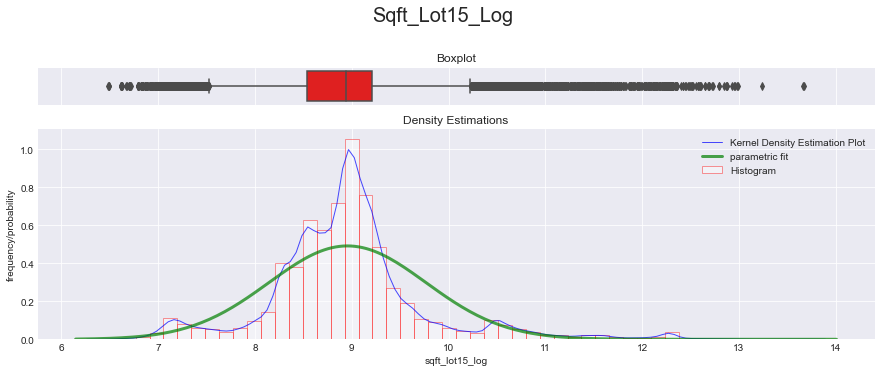

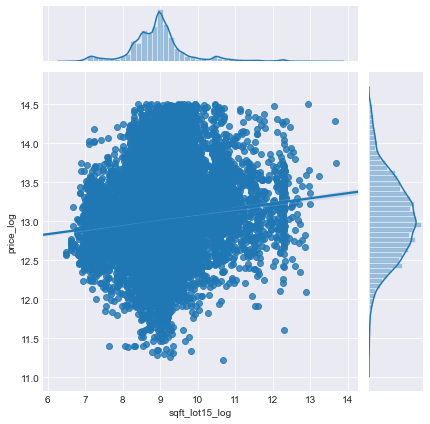

In [251]:
# distribution of lot areas - as is
data = pd.concat([df['price_log'], df['sqft_lot15'], df['sqft_lot15'].apply(np.log)], axis=1)
data.columns = ['price_log', 'sqft_lot15', 'sqft_lot15_log']

check_distribution(cols=['sqft_lot15'], df=data)
a = sns.jointplot(x='sqft_lot15', y='price_log', data=data, kind='reg')


# distribution of lot areas - log transformed 

check_distribution(cols=['sqft_lot15_log'], df=data)

a = sns.jointplot(x='sqft_lot15_log', y='price_log', data=data, kind='reg')

- log transformation has improved the distribution by reducing skew and making it look more normal
- linear relationship with price exists, but data show high heteroscedasticity

In [252]:
df['sqft_lot15_log'] = df['sqft_lot15'].apply(np.log)
X_cols.append('sqft_lot15_log')

### grade

An index from 1 to 13, where 1-3 falls short of building construction and design, 7-10 has an average level of construction and design, and 11-13 have a high quality level of construction and design.

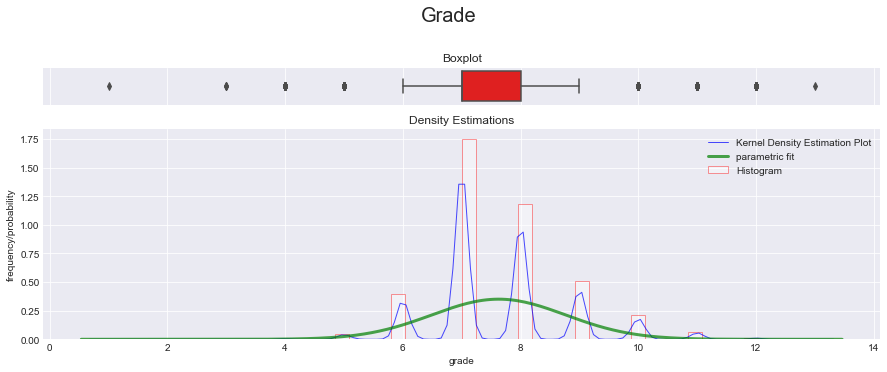

In [253]:
check_distribution(cols=['grade'], df=df)

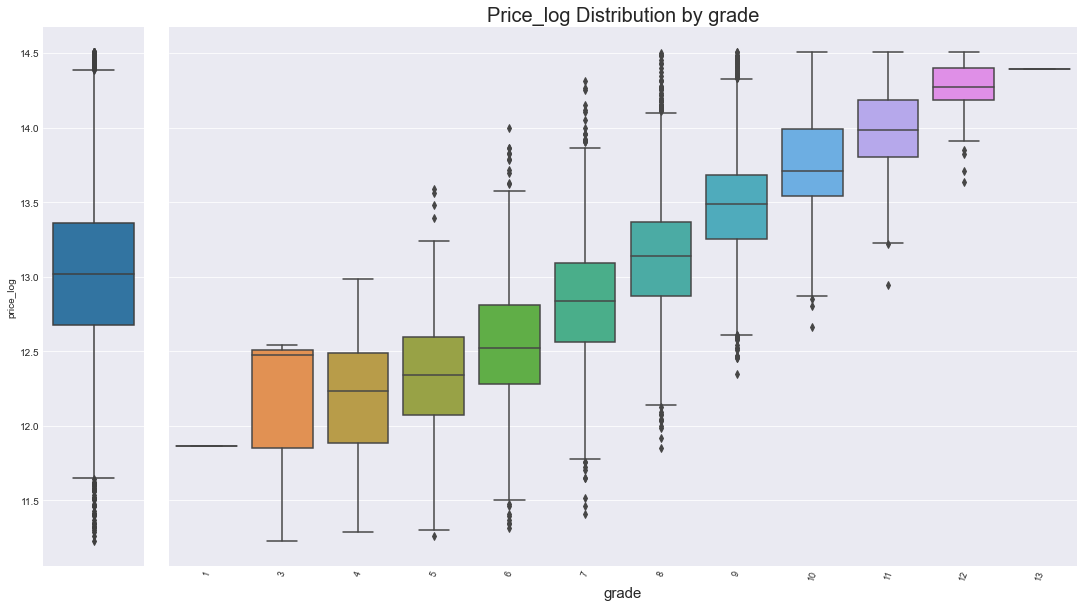

In [254]:
f, axes = plt.subplots(1, 2, figsize=(15,8), sharey = True, gridspec_kw={"width_ratios": (.1, .9)})
f.tight_layout()

a = sns.boxplot(x=df['price_log'], orient='v', ax=axes[0])

b = sns.boxplot(x=df["grade"], y=df['price_log'], ax=axes[1])
b.set_title("Price_log Distribution by grade",fontsize=20)
b.set_xlabel("grade",fontsize=15)
b.set_ylabel("",)
b.tick_params(labelsize=9)

plt.xticks(rotation=70)

plt.show()

- there is a linear relationship between 'grade' and the price_log
- treating 'grade' as a non-linear categorical variable will provide more flexibility in differentiating different grade levels

In [255]:
categorical.append('grade')

### condition

An index from 1 to 5 on the condition of the property

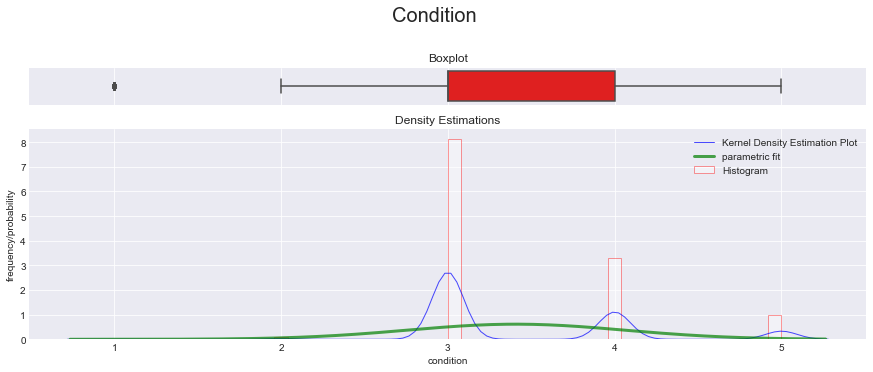

In [256]:
check_distribution(['condition'])

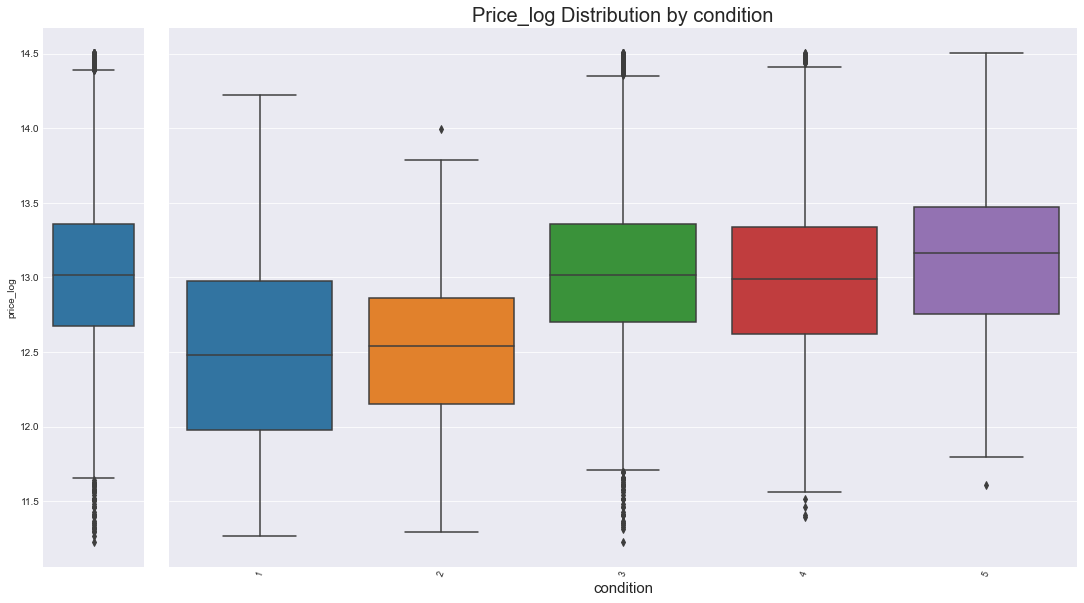

In [257]:
boxplots_category('condition')

In [258]:
categorical.append('condition')

### yr_built

In [259]:
filt = (df['date'].dt.year.astype('int') - df['yr_built']) < 0
df.loc[filt, 'yr_built'] = df.loc[filt, 'date'].dt.year.astype('int') 

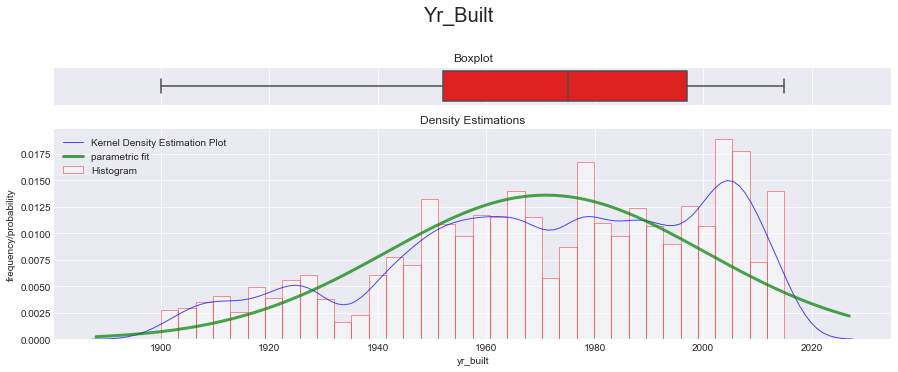

In [260]:
check_distribution(cols=['yr_built'], df=df)

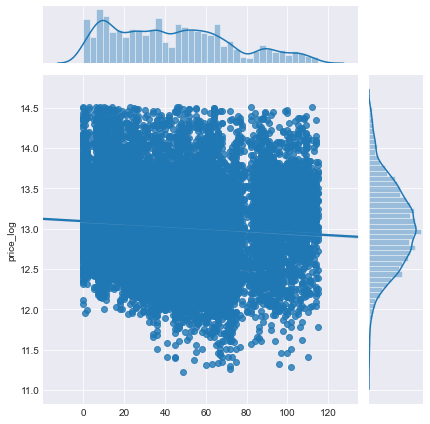

In [261]:
sns.jointplot(x=df['date'].dt.year-df['yr_built'], y=df['price_log'], kind='reg')

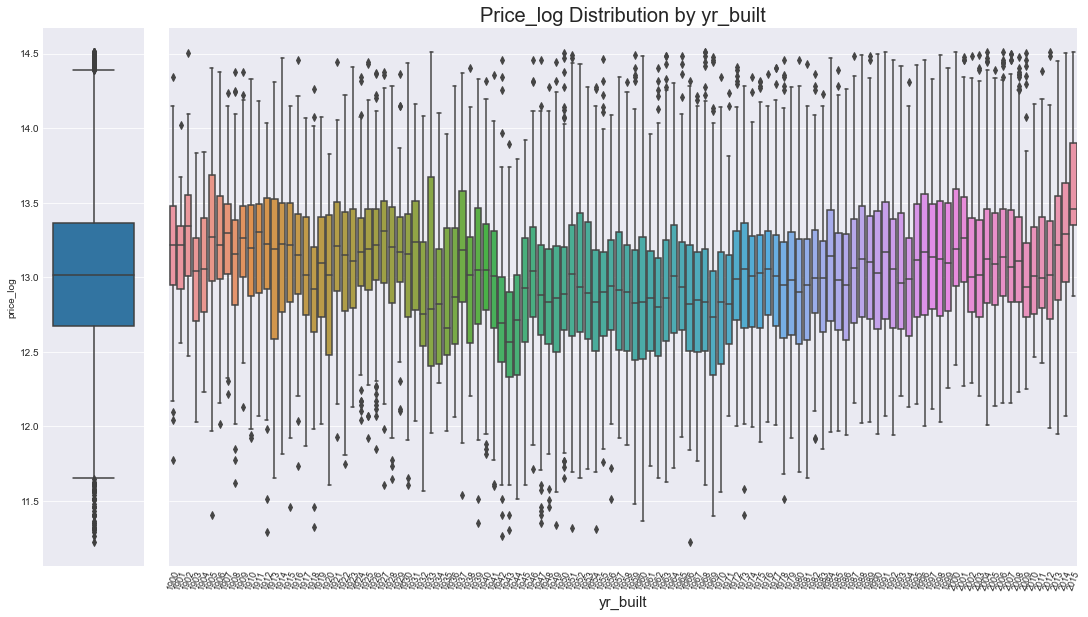

In [262]:

boxplots_category('yr_built')

- there doesn't seem to be a linear correlation between yr_built and the log of the price
- this variable should be treated as a categorical variable, 

A possible assumption is that specific vintage styles could be priced differently , and/or that housing development in a given year might be correlated with specific locations, as shown below

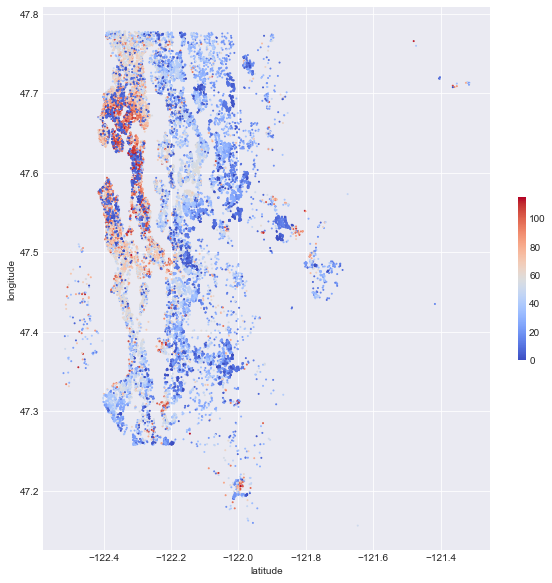

In [263]:
f = plt.figure(figsize=(10, 10))
plt.scatter(x=df['long'], y=df['lat'], 
            c=df['date'].dt.year.astype('int')-df['yr_built'], 
            s=1,
            cmap='coolwarm', 
#             alpha=0.3
           )
plt.colorbar(shrink=0.3)
plt.xlabel('latitude')
plt.ylabel('longitude')
plt.show()


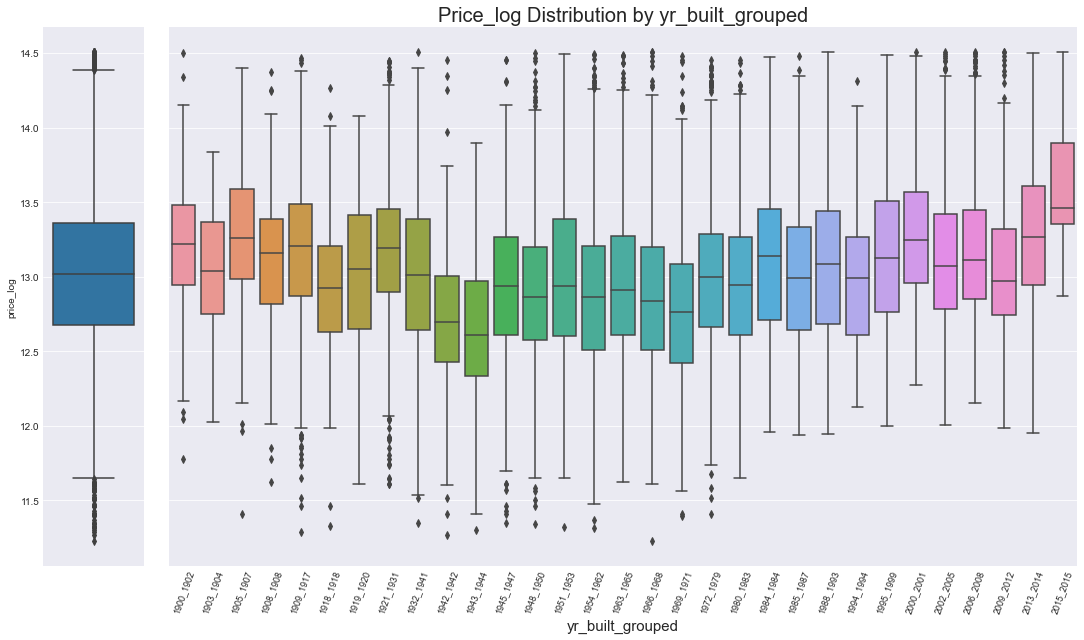

In [264]:
def group_numerical_categories(col, df=df):
    dummies = pd.get_dummies(df[col])
    new_group = []
    grouped_years = []
    all_years = df[col].sort_values().unique()
    for yr in all_years:
        if new_group:
            new_group.append(yr)
            _, p_value = f_oneway(*[
                df.loc[dummies[yr_].astype(bool), 'price_log'
                      ].values for yr_ in new_group])

            if p_value < 0.05:
                # consolidates group
                new_group_seed = new_group.pop()
                grouped_years.append(new_group)
                new_group = [new_group_seed]
                if all_years[-1] == yr:
                    grouped_years.append([yr])
            elif all_years[-1] == yr:
                grouped_years.append(new_group)
        else:
            new_group.append(yr)
        
    group_names = [[str(group[0]) +'_' + str(group[-1])]*len(group) for group in grouped_years]
    yrs_mapping = dict()
    for grouped_year, group_name in zip(grouped_years, group_names):
        for yr, name in zip(grouped_year, group_name):
            yrs_mapping[yr] = name
    return pd.Series(df[col].map(yrs_mapping))


df['yr_built_grouped'] = group_numerical_categories('yr_built', df=df)

boxplots_category('yr_built_grouped')

In [265]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

dummies = pd.get_dummies(df['yr_built_grouped'].astype('category'), drop_first=True)


# # dummies.columns = [str(col) for col in dummies.columns]
# digits = ['Zero', 'One', 'Two', 'Three', 'Tour', 'Five', 'Six', 'Seven', 'Eight', 'Nine']
# col_names = []
# for col in dummies.columns:
#     name = "_".join([digits[int(digit)] for digit in (str(col))])
#     name = 'Built_In_'+name
#     col_names.append(name)

# dummies.columns = col_names

formula_strings = ['+ C(Q({}))'.format('"'+str(col)+'"') for col in dummies.columns]

data = pd.concat([df['price_log'], dummies.astype('category')], axis=1)
formula = 'price_log ~' + ' '.join(formula_strings)[1:]


lm = ols(formula, data).fit()
table = pd.DataFrame(sm.stats.anova_lm(lm, typ=2).to_dict())
filt = table['PR(>F)']<0.05
table[filt]
# table


,sum_sq,df,F,PR(>F)
"C(Q(""1903_1904""))",1.203340,1.0,5.179765,2.286125e-02
"C(Q(""1918_1918""))",4.760316,1.0,20.490734,6.024364e-06
"C(Q(""1919_1920""))",2.215170,1.0,9.535177,2.018287e-03
"C(Q(""1932_1941""))",3.249414,1.0,13.987070,1.845524e-04
"C(Q(""1942_1942""))",19.039395,1.0,81.954888,1.508585e-19
"C(Q(""1943_1944""))",28.769192,1.0,123.836704,1.096709e-28
"C(Q(""1945_1947""))",7.403539,1.0,31.868460,1.670656e-08
"C(Q(""1948_1950""))",10.075001,1.0,43.367744,4.641401e-11
"C(Q(""1951_1953""))",4.332230,1.0,18.648041,1.579164e-05
"C(Q(""1954_1962""))",12.690098,1.0,54.624402,1.512748e-13


In [266]:
categorical.append('yr_built_grouped')

### yr_renovated

In [267]:
filt = (df['date'].dt.year.astype('int') - df['yr_renovated']) < 0
df.loc[filt, 'yr_renovated'] = df.loc[filt, 'date'].dt.year.astype('int') 

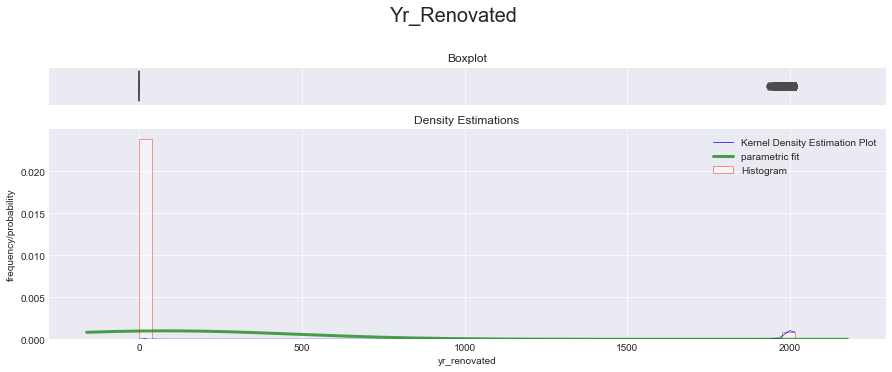

In [268]:
check_distribution(cols=['yr_renovated'])

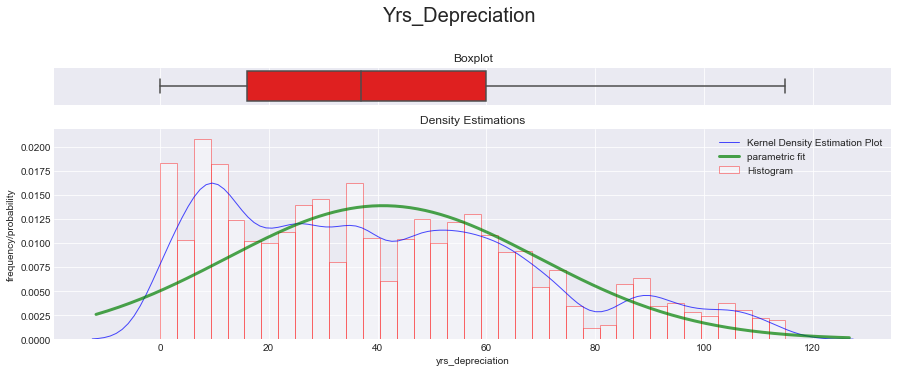

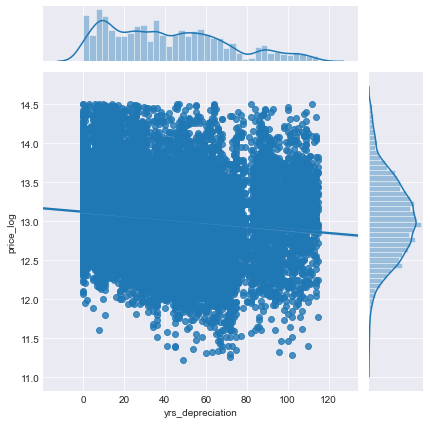

In [269]:
data = df[['yr_renovated', 'price_log', 'yr_built']]
data['yr'] = df['date'].dt.year.astype('int')
data['yrs_depreciation'] = [
    min(since_ren, since_built) for since_ren, since_built in zip(
        data['yr'] - data['yr_renovated'], data['yr'] - data['yr_built'])]

check_distribution(cols=['yrs_depreciation'], df=data)
sns.jointplot(x=data['yrs_depreciation'], y=data['price_log'], kind='reg')
plt.show()

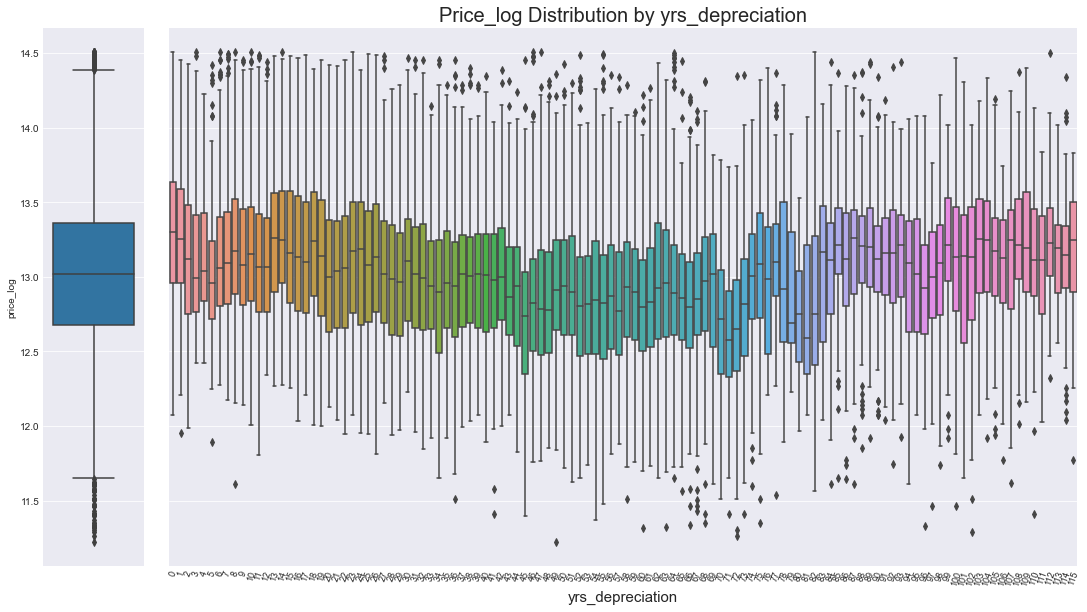

In [270]:
boxplots_category('yrs_depreciation', df=data)

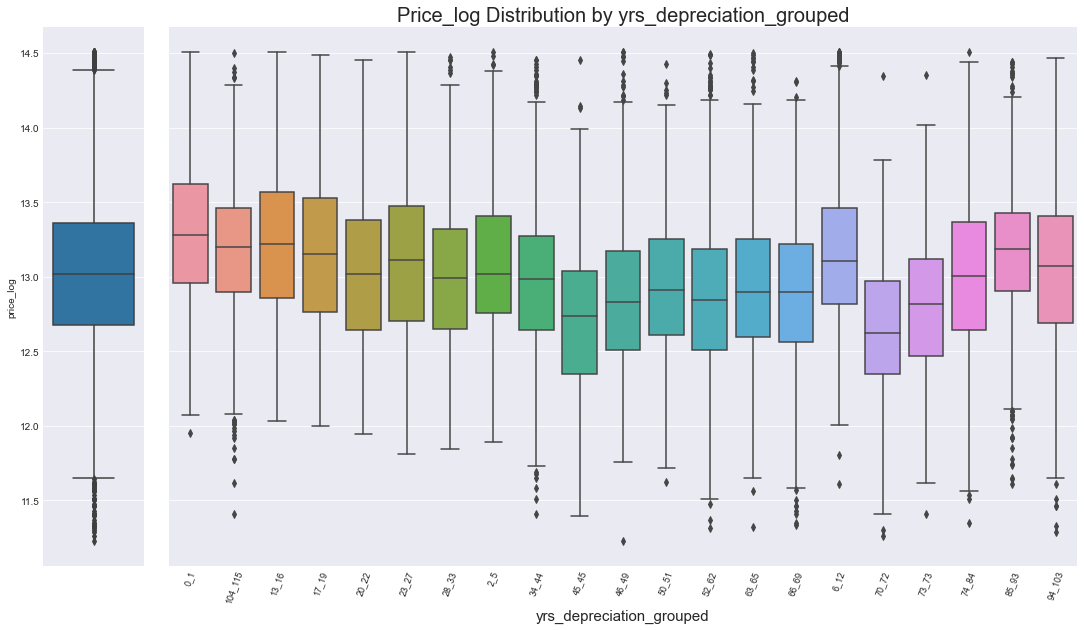

In [271]:
df['yrs_depreciation_grouped'] = group_numerical_categories('yrs_depreciation', df=data)

boxplots_category('yrs_depreciation_grouped')

In [272]:
categorical.append('yrs_depreciation_grouped')

### Zip-codes

We shall investigate the distribution of price_log in each zip-code. It will provide us with a first impression on the relationship between outliers and zip-codes.

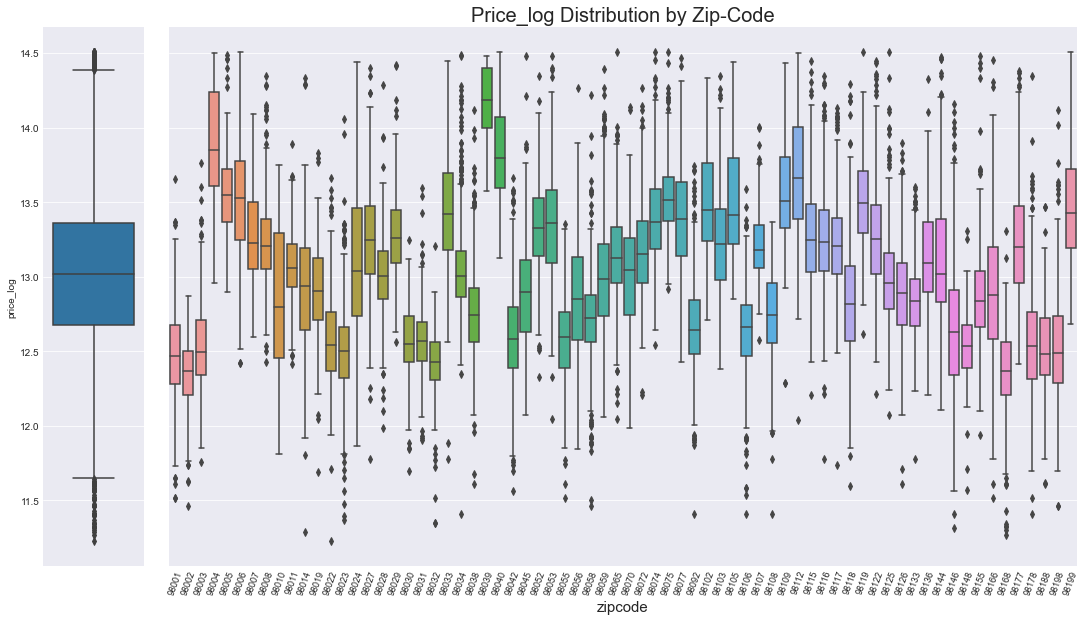

In [273]:
# zip-codes boxplots of price 
f, axes = plt.subplots(1, 2, figsize=(15,8), sharey = True, gridspec_kw={"width_ratios": (.1, .9)})
f.tight_layout()
data = df[[ 'zipcode', 'price_log']]

a = sns.boxplot(x=data['price_log'], orient='v', ax=axes[0])

b = sns.boxplot(x=df["zipcode"], y=data['price_log'], ax=axes[1])
b.set_title("Price_log Distribution by Zip-Code",fontsize=20)
b.set_xlabel("zipcode",fontsize=15)
b.set_ylabel("",)
b.tick_params(labelsize=9)

plt.xticks(rotation=70)

plt.show()

- All zip-code price distributions are heavily influenced by outliers
- A few zip-code price distributions have large a intersection  with the outliers area of the overall distribution. This one  indication that outliers are not incorrect data.

In [274]:
categorical.append('zipcode')

### Bedrooms

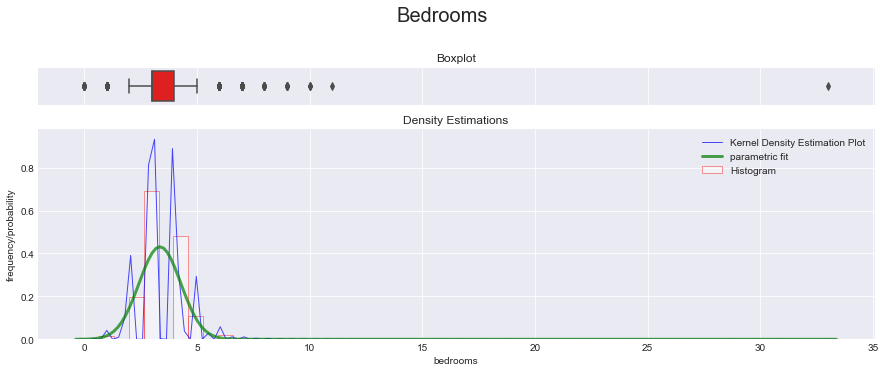

In [275]:
check_distribution(cols=['bedrooms'], df=df)

In [276]:
filt = df['bedrooms'] > 15
print('number of bedrooms per 1000 sqft: ', (df.loc[filt, 'bedrooms'] / df.loc[filt, 'sqft_living'] * 1000).values)
df.drop(index=df[filt].index, inplace=True)

number of bedrooms per 1000 sqft:  [20.37037037]


- distribution is heavily influenced by outliers
- one outlier value refers to a property with more than 20 bedrooms per 1000 sqft, which indicates that this data point is a mistake

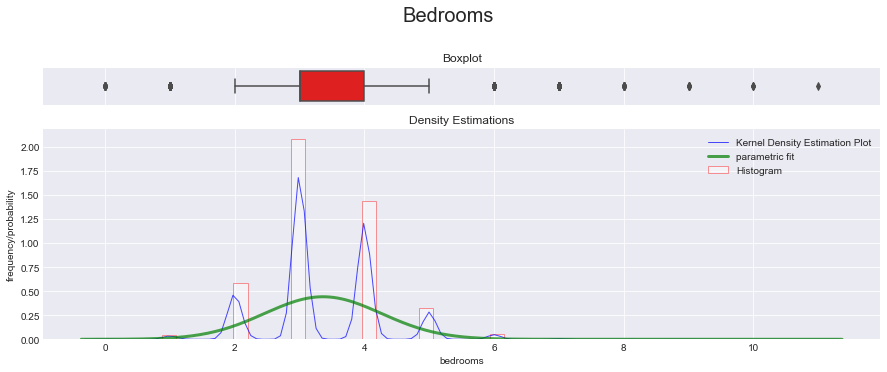

In [277]:
check_distribution(cols=['bedrooms'], df=df)

- the influence of outliers on the distribution was diminished by excluding outlier
- Distribution looks normal enough

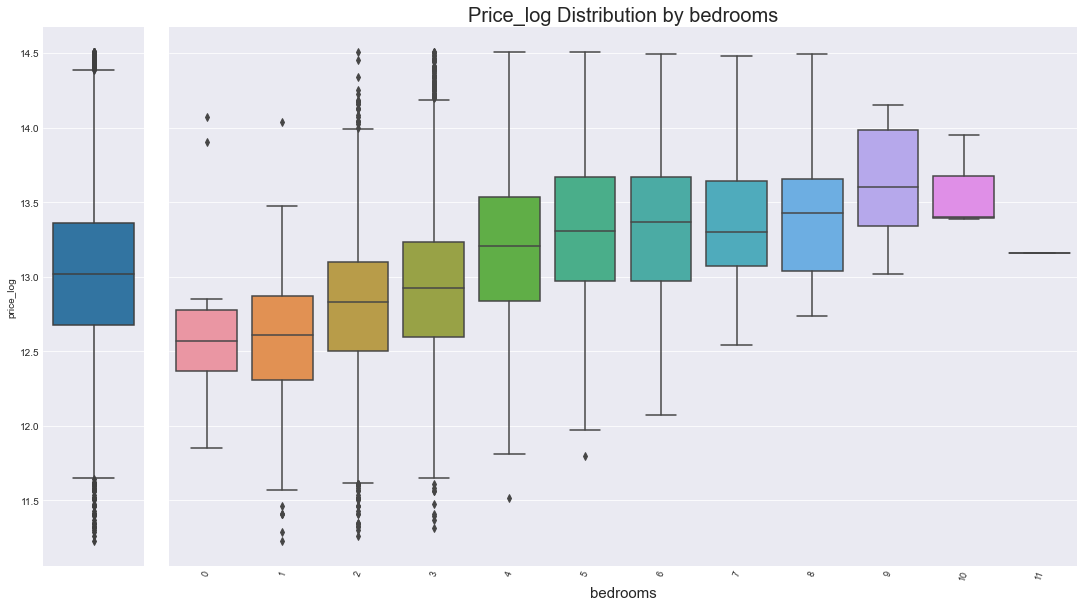

In [278]:
boxplots_category('bedrooms')

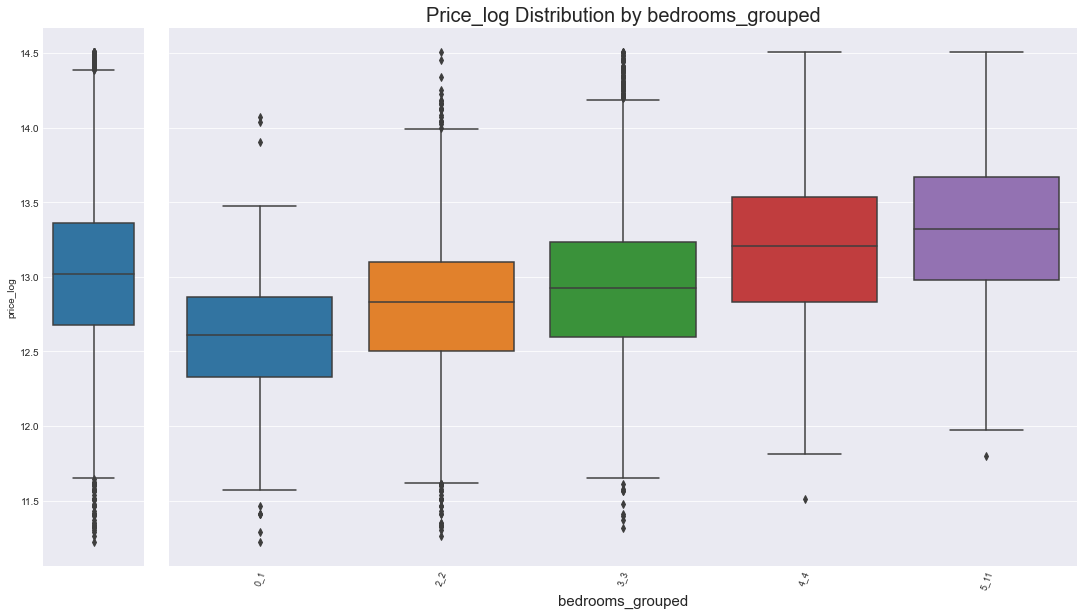

In [279]:
data = df[['price_log', 'bedrooms']]
data['bedrooms_grouped'] = group_numerical_categories('bedrooms', df=data)
boxplots_category('bedrooms_grouped', df=data)

- positive correlation

In [280]:
df['bedrooms_grouped'] = group_numerical_categories('bedrooms', df=df)
categorical.append('bedrooms_grouped')

### Bathrooms

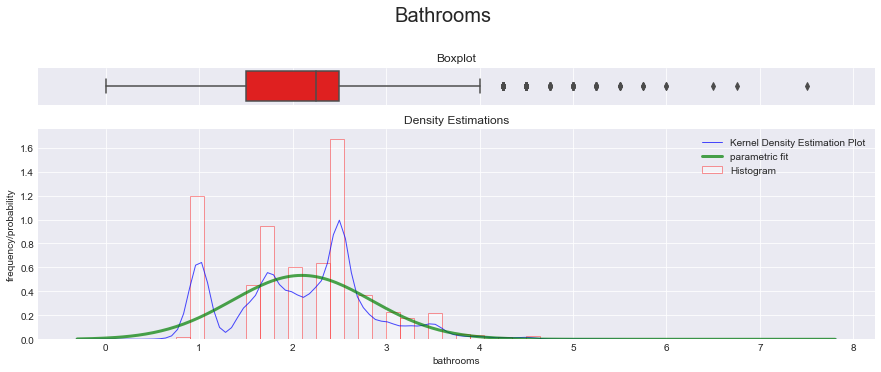

In [281]:
check_distribution(cols=['bathrooms'])

In [282]:
filt = (df['bathrooms'] / df['sqft_living']) * 1000 > 5
df[filt]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_lot15,price_log,sqft_living_log,sqft_living15_log,sqft_above_log,sqft_lot_log,sqft_lot15_log,yr_built_grouped,yrs_depreciation_grouped,bedrooms_grouped


- Assuming that a reasonable top threshold for bathrooms 5 per 1000 square feet, there are no incoherent outliers in the distribution.
- distribution looks somewhat normal, even though it is skewed

- the influence of outliers on the distribution was diminished by the log transformation
- Distribution looks normal enough

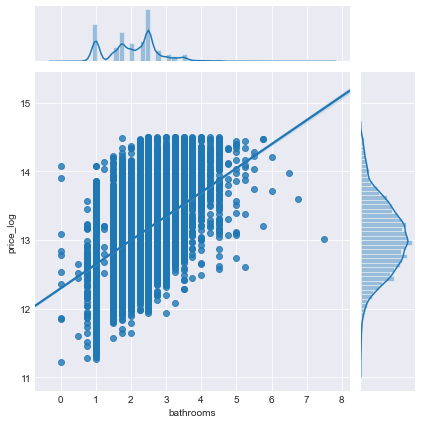

In [283]:
sns.jointplot(x=df['bathrooms'], y=df['price_log'], kind='reg')

- positive linear correlation is observed

In [284]:
X_cols.append('bathrooms')

### Floors

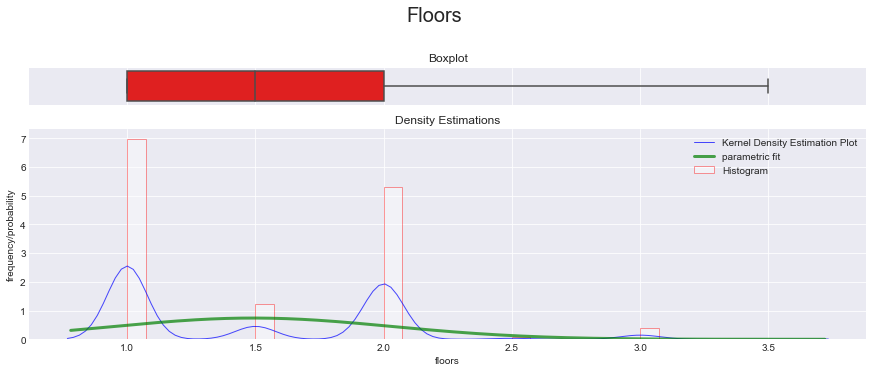

In [285]:
check_distribution(cols=['floors'])

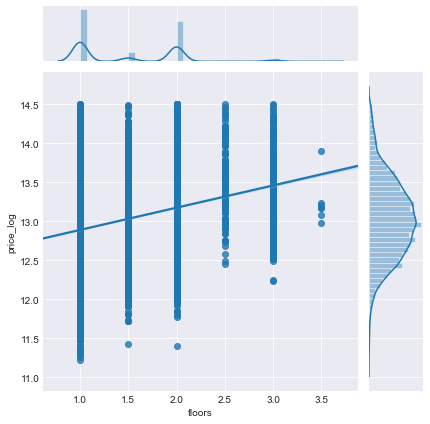

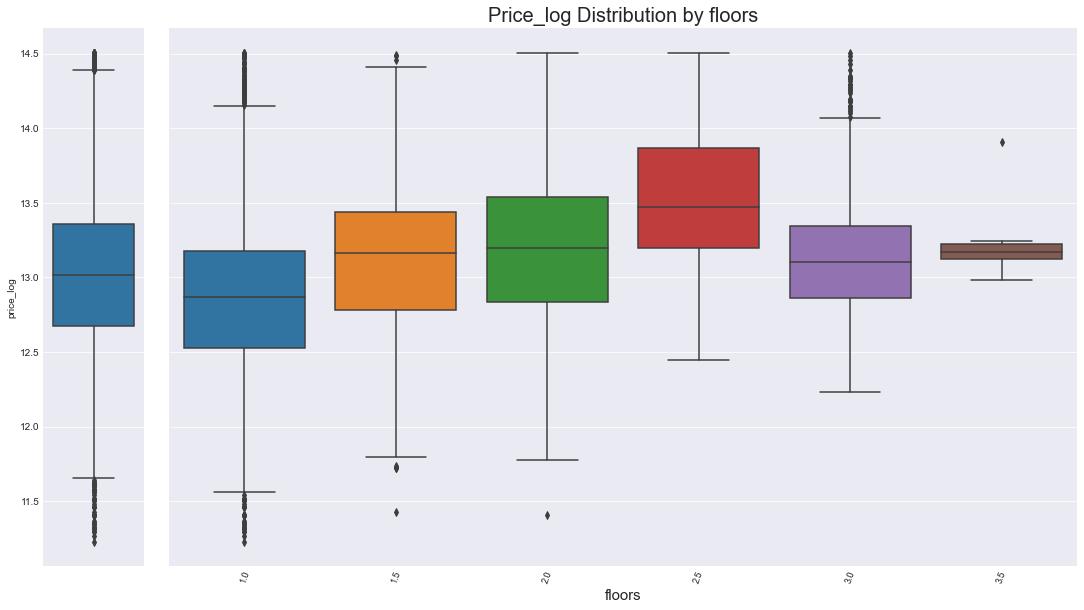

In [286]:
sns.jointplot(x='floors', y='price_log', data=df, kind='reg')
boxplots_category('floors')

- no clear linear correlation
- distribution not Normal

In [287]:
categorical.append('floors')

### waterfront

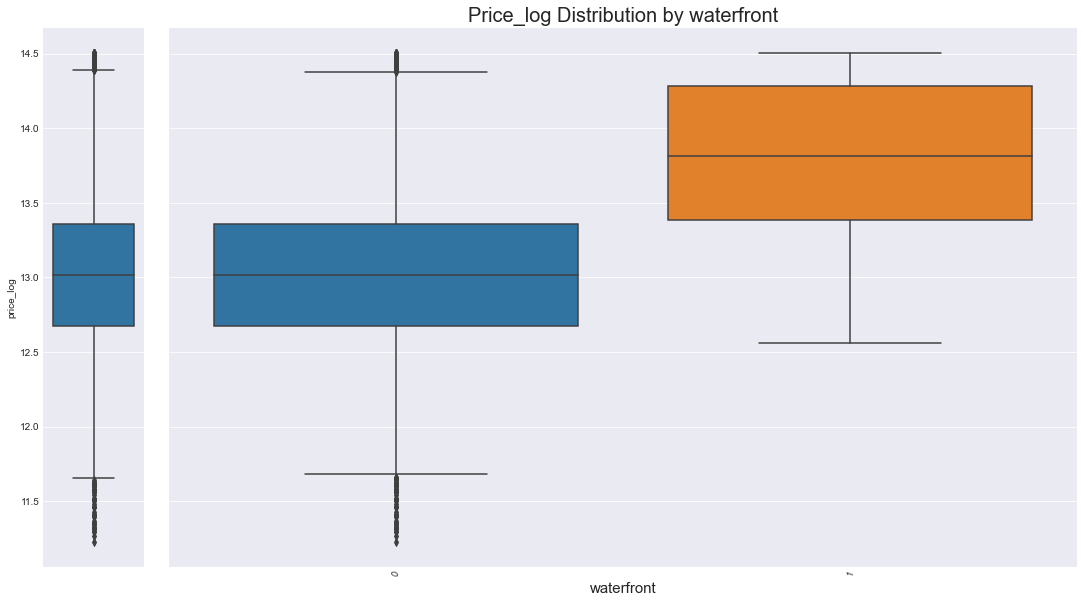

In [288]:
boxplots_category('waterfront')

In [289]:
categorical.append('waterfront')

### view

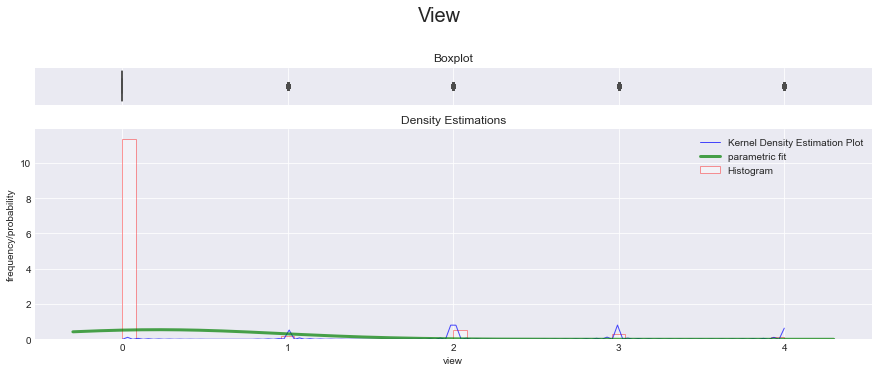

In [290]:
check_distribution(['view'])

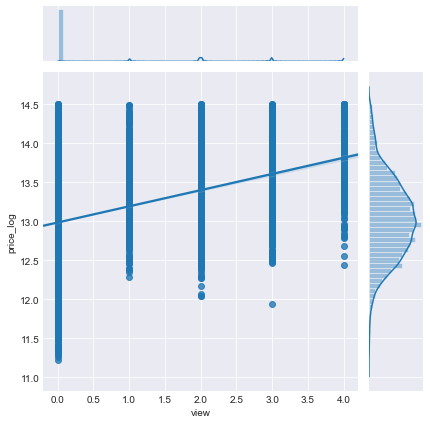

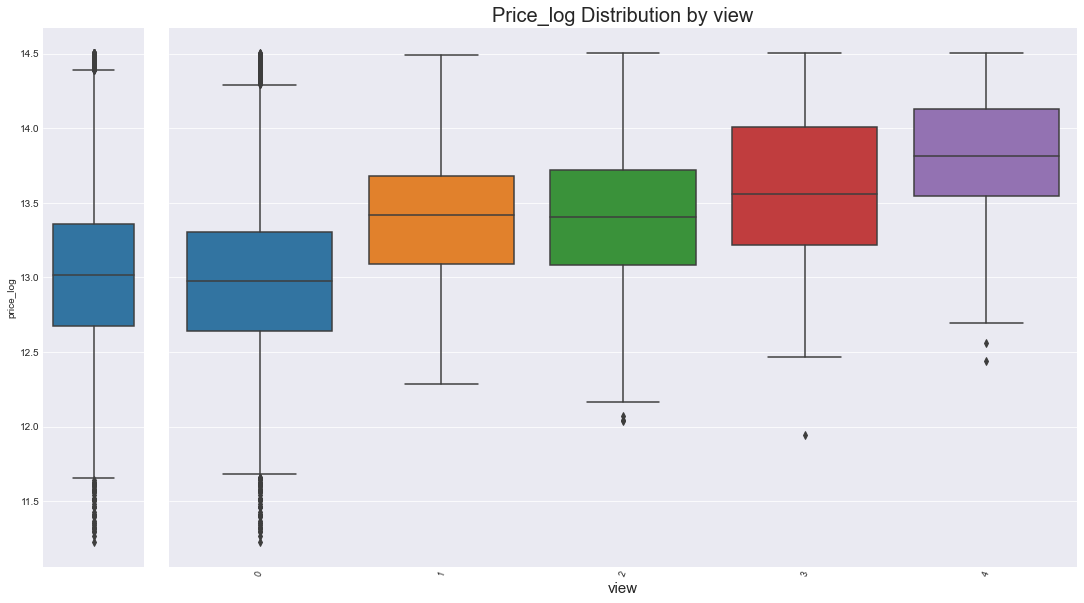

In [291]:
sns.jointplot(x=df['view'], y=df['price_log'], kind='reg')
boxplots_category('view')

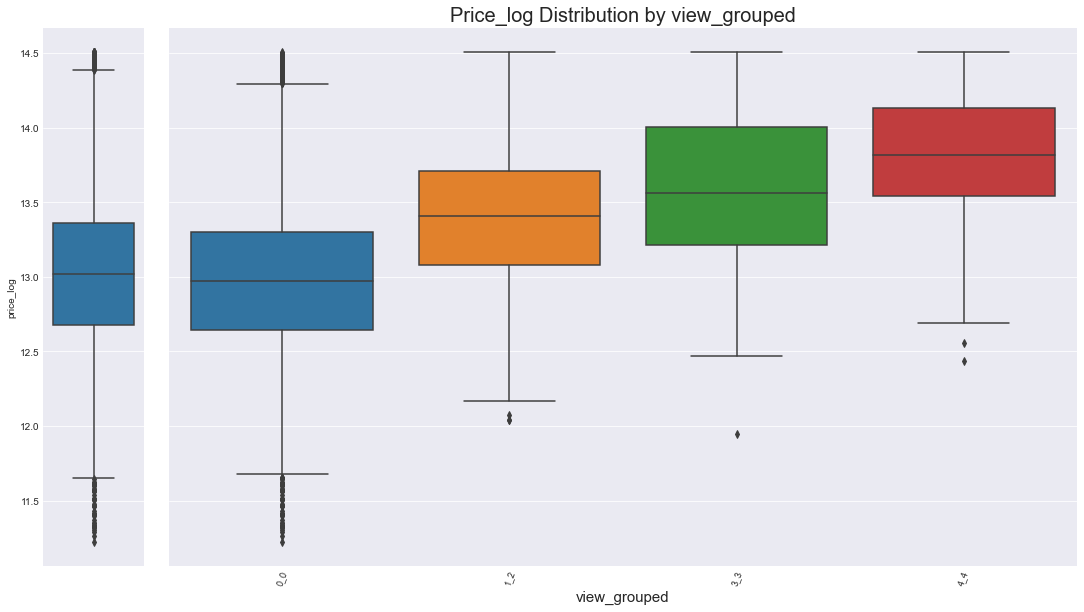

In [292]:
data = df[['price_log', 'view']]
data['view_grouped'] = group_numerical_categories('view', df=data)
boxplots_category('view_grouped', data.sort_values(by='view_grouped'))

- even though a linear relationship can be established, the increment in price given an increment in the view score is not consistent throughout view scores
- treating the variables as a category will provide for more flexibility and accuracy 

In [293]:
df['view_grouped'] = group_numerical_categories('view', df=df)
categorical.append('view_grouped')

# Train-Test Split, Transformations, Scaling

In [294]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21612 entries, 0 to 21611
Columns: 155 entries, sqft_living_log to view_grouped_4_4
dtypes: category(148), float64(6), int64(1)
memory usage: 4.2 MB


In [296]:
df.reset_index(inplace=True, drop=True)
X = pd.concat([df[X_cols], pd.get_dummies(df[categorical].astype('category'),
                                          drop_first=True).astype('category')], 
              axis=1)
Y = df[['price']]
# Y = df[['price_log']]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3,
                                                    random_state=42)

mms = MinMaxScaler()

X_train_scaled = pd.DataFrame(mms.fit_transform(X_train),
                              columns=X_train.columns)
X_test_scaled = pd.DataFrame(mms.transform(X_test),
                             columns=X_test.columns)


In [297]:

formula_strings = ['+ Q({})'.format('"'+str(col)+'"') for col in X_train_scaled.columns]
data = pd.concat([y_train, X_train_scaled], axis=1)

formula = 'price ~' + ' '.join(formula_strings)[1:]
# formula = 'price_log ~' + ' '.join(formula_strings)[1:]


lm = ols(formula, data).fit()
# lm.summary()
table = pd.DataFrame(sm.stats.anova_lm(lm, typ=2).to_dict())
filt = table['PR(>F)']<0.05
table[filt]
# table


,sum_sq,df,F,PR(>F)
"Q(""condition_2"")",4.764676e+11,1.0,5.891665,0.015230
"Q(""grade_12"")",3.554729e+11,1.0,4.395529,0.036058
"Q(""yr_built_grouped_1905_1907"")",5.897934e+11,1.0,7.292972,0.006934
"Q(""yr_built_grouped_1908_1908"")",4.607473e+11,1.0,5.697278,0.017009
"Q(""yrs_depreciation_grouped_73_73"")",3.188539e+11,1.0,3.942724,0.047101
"Q(""zipcode_98029"")",3.331736e+11,1.0,4.119792,0.042410
"Q(""zipcode_98033"")",4.616378e+11,1.0,5.708289,0.016903
"Q(""zipcode_98065"")",4.895205e+11,1.0,6.053067,0.013898
"Q(""zipcode_98107"")",3.110175e+11,1.0,3.845825,0.049897
"Q(""zipcode_98108"")",3.158475e+11,1.0,3.905549,0.048154


# Multicollinearity

In [ ]:

def create_colinearity_df(correlation_hurdle, variables_list, df):
    """Function that finds which variables have correlation above a 
    certain threshold.
    
    ***
    Function takes in as arguments a correlation hurdle, a list of variables 
    and a Data Frame.
    
    Returns a correlation matrix as a pandas Data Frame
    ***
    Arguments:
    - correlation_hurdle : float between 0 and 1
    - variables_list: list of strings with variable names. Must be a column 
    name of the provided data frame
    - df : a DataFrame containing the data for the variables.
    
    """
    
    # creates a new df from a correlation matrix
    # multi index structure 
    correlations_df = pd.DataFrame(
        df[variables_list].corr().stack()).reset_index()
    
    # removes redundant correlations
    index_drop = correlations_df[
        correlations_df['level_0'] == correlations_df['level_1']].index
    correlations_df.drop(index=index_drop, inplace=True)

    # renames columns, resets index
    correlations_df.columns= ['x', 'y', 'corr']
    correlations_df.reset_index(inplace=True)
    correlations_df.drop(columns='index', inplace=True)
    
    # creates new column with the correlated pairs
    correlations_df['pair'] = [tuple(set([i, j])) for i, j in zip(correlations_df['x'], correlations_df['y'])]
    
    # drops duplicates
    correlations_df.drop_duplicates(subset='pair', inplace=True)
    
    # sets the pairs as new index
    correlations_df.set_index('pair', inplace=True)
    
    # returns only pairs with correlation above hurdle
    correlations_df = correlations_df[abs(correlations_df['corr']) > correlation_hurdle] 
    
    # stores the correlated features
    corr_features = set(correlations_df['x'].values)
    corr_features.update(correlations_df['y'].values)
    corr_features = list(corr_features)
    
    # drops columns used to create the pairs' column
    correlations_df.drop(columns=['x', 'y'], inplace=True)
    
    return correlations_df, corr_features


In [ ]:
correlations_df, corr_features = create_colinearity_df(0.7, X_cols, df)
print(corr_features)
correlations_df

In [ ]:
# how many combinations of uncorrelated features?

# all combinations with n variables (n: 1->5)
from itertools import combinations
combinations_list = []
for i in range(1, 6):
    for item in list(combinations(corr_features, i)):
        combinations_list.append(item)

# all combinations of features with no collinearity
not_collinear_combinations = []
for combination in combinations_list:
    remaining = list(set(corr_features) - set(combination))
    new_correlations_df, new_corr_features = create_colinearity_df(0.7, remaining, 
                                                                df[remaining])
    pairs = list(new_correlations_df.index)
    if not pairs:
        not_collinear_combinations.append(list(combination))
    
# selects the combination with highest r-squared
adj_rsquared = 0
for combination in not_collinear_combinations:
    remaining = list(set(corr_features) - set(combination))
    f = "+".join(remaining)
    f = 'price~'+f
    model = ols(formula=f, data=df).fit()
    print(model.rsquared_adj)
    if model.rsquared_adj > adj_rsquared:
        adj_rsquared = model.rsquared_adj
        selected_not_collinear_features = list(remaining)
        
selected_not_collinear_features, adj_rsquared
    

# end

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib
from sklearn.linear_model import LinearRegression
from sklearn import svm
from sklearn import tree

X = df[X_cols]
Y = df[Y]

# Load and split the data
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y, 
                                                    test_size=0.3, 
                                                    random_state=42)

# Construct some pipelines
pipe_lr = Pipeline([('scl', MinMaxScaler()),
                    ('est', LinearRegression(random_state=42))])
pipe.fit(X_train, y_train)

# Compare accuracies
for idx, val in enumerate(pipelines):
	print('%s pipeline test accuracy: %.3f' % (pipe_dict[idx], val.score(X_test, y_test)))

# Identify the most accurate model on test data
best_acc = 0.0
best_clf = 0
best_pipe = ''
for idx, val in enumerate(pipelines):
	if val.score(X_test, y_test) > best_acc:
		best_acc = val.score(X_test, y_test)
		best_pipe = val
		best_clf = idx
print('Classifier with best accuracy: %s' % pipe_dict[best_clf])
